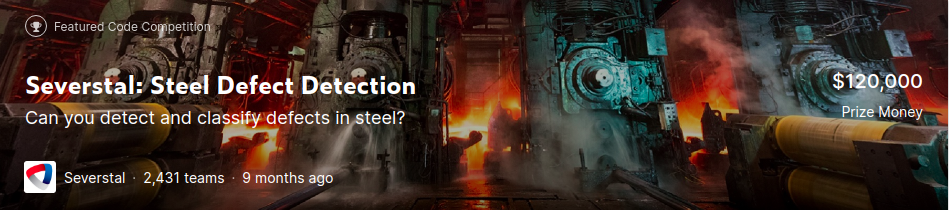

# Introduction

# TEAM

### Rishabh Tiwari - [LINKEDIN](https://www.linkedin.com/in/rishabh-tiwari16/)

### Udbhav Bamba - [LINKEDIN](https://www.linkedin.com/in/ubamba98/)

### Arnav Chavan - [LINKEDIN](https://www.linkedin.com/in/arnav0400/)

# LINKS
Inference Kernel:https://www.kaggle.com/carnav0400/individual-models-normal-pytorch-main-600-6b2ed3?scriptVersionId=22491812

PPT LINK [HOW TO START ML]: https://docs.google.com/presentation/d/1AxVeCddee9suKg5iPrQ0AvfAQFjTsEfGv6mAU04iGvs/edit?usp=sharing

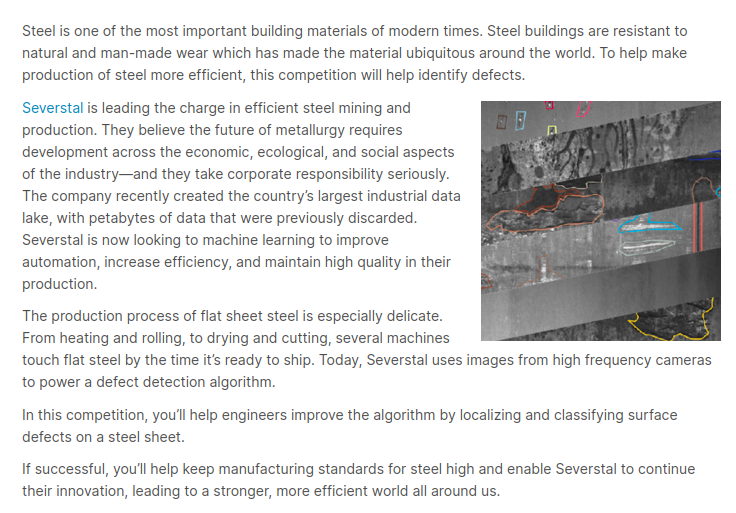

# Task:
## Semantic Segmentation

![image.png](https://miro.medium.com/max/500/1*RZnBSB3QpkIwFUTRFaWDYg.gif)

# Evaluation Metric
### Dice Coefficient (F1 Score) : 
Simply put, the Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images.
To know more refer [here](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)

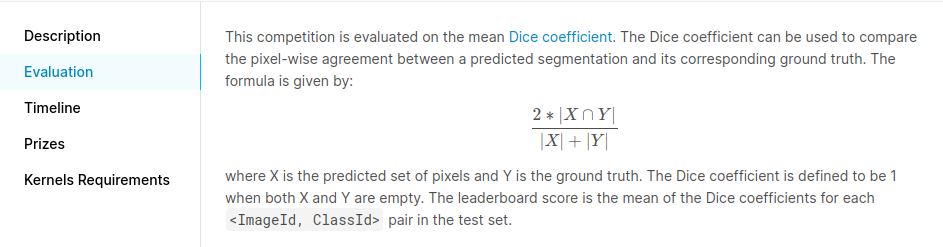

### Downloading DATA

In [1]:
import os
os.environ['KAGGLE_USERNAME']='rishabh2001'
os.environ['KAGGLE_KEY']=''

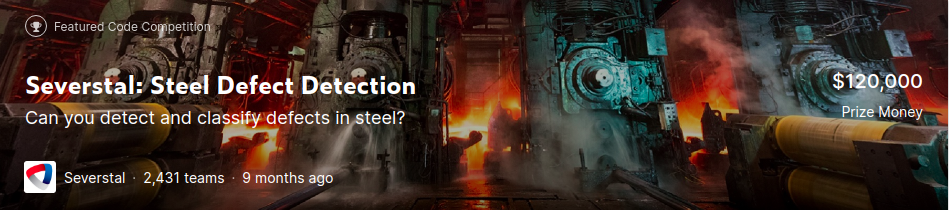

In [2]:
!kaggle competitions download -c severstal-steel-defect-detection

401 - Unauthorized


In [3]:
!unzip '*.zip'

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [4]:
!rm *.zip

rm: cannot remove '*.zip': No such file or directory


In [5]:
!python prepare_csv.py

Traceback (most recent call last):
  File "prepare_csv.py", line 8, in <module>
    d[train_df.iloc[i,0]+'_'+str(train_df.iloc[i,1])] = train_df.iloc[i,2]
  File "/home/rishabh-16/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py", line 1494, in __getitem__
    return self._getitem_tuple(key)
  File "/home/rishabh-16/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py", line 2143, in _getitem_tuple
    self._has_valid_tuple(tup)
  File "/home/rishabh-16/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py", line 223, in _has_valid_tuple
    self._validate_key(k, i)
  File "/home/rishabh-16/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py", line 2070, in _validate_key
    self._validate_integer(key, axis)
  File "/home/rishabh-16/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py", line 2139, in _validate_integer
    raise IndexError("single positional indexer is out-of-bounds")
IndexError: single positional indexer is out-of-bounds

# EDA

In [6]:
# Most of the code is taken from here - https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda

In [7]:
import numpy as np
import pandas as pd
import os
import cv2
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import math
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import cv2
from tqdm.notebook import tqdm

In [8]:
train_df = pd.read_csv("train.csv")
sample_df = pd.read_csv("sample_submission.csv")

In [9]:
train_df.head()

ImageId_ClassId                                      EncodedPixels
0  cbfeaed02.jpg_1                                                NaN
1  cbfeaed02.jpg_2                                                NaN
2  cbfeaed02.jpg_3                                                NaN
3  cbfeaed02.jpg_4  67239 21 67491 47 67745 60 68000 63 68255 66 6...
4  01764ee81.jpg_1                                                NaN

### Number of images with defects

In [10]:
class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_defects_num = 0
defects_num = 0

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        no_defects_num += 1
    else:
        defects_num += 1
    
    kind_class_dict[sum(labels.isna().values == False)] += 1
        
    for idx, label in enumerate(labels.isna().values.tolist()):
        if label == False:
            class_dict[idx+1] += 1

In [11]:
print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))

the number of images with no defects: 5902
the number of images with defects: 6666


### Number of images for each class

defaultdict(int, {1: 897, 2: 247, 3: 5150, 4: 801})

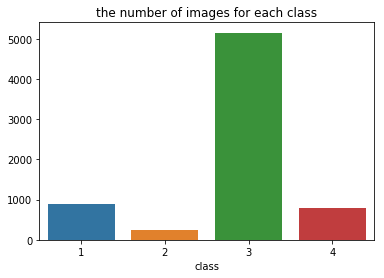

In [12]:
fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
class_dict

### Number of Classes in Each Image

defaultdict(int, {0: 5902, 1: 6239, 2: 425, 3: 2})

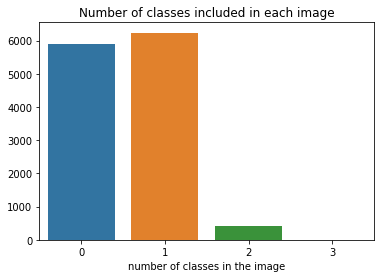

In [13]:
fig, ax = plt.subplots()
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()), ax=ax)
ax.set_title("Number of classes included in each image");
ax.set_xlabel("number of classes in the image")
kind_class_dict

### Distribution of Image Size

In [14]:
train_size_dict = defaultdict(int)
train_path = Path("train_images/")

for img_name in train_path.iterdir():
    img = Image.open(img_name)
    train_size_dict[img.size] += 1

In [15]:
train_size_dict

defaultdict(int, {(1600, 256): 12568})

In [27]:
test_size_dict = defaultdict(int)
test_path = Path("test_images/")

for img_name in test_path.iterdir():
    img = Image.open(img_name)
    test_size_dict[img.size] += 1

In [28]:
test_size_dict

defaultdict(int, {(1600, 256): 5506})

### Visualizing Masks

In [18]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]
def name_and_mask(start_idx):
    col = start_idx
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError

    labels = train_df.iloc[col:col+4, 1]
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx] = mask_label.reshape(256, 1600, order='F')
    return img_names[0], mask

def show_mask_image(col):
    name, mask = name_and_mask(col)
    img = cv2.imread(str(train_path / name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

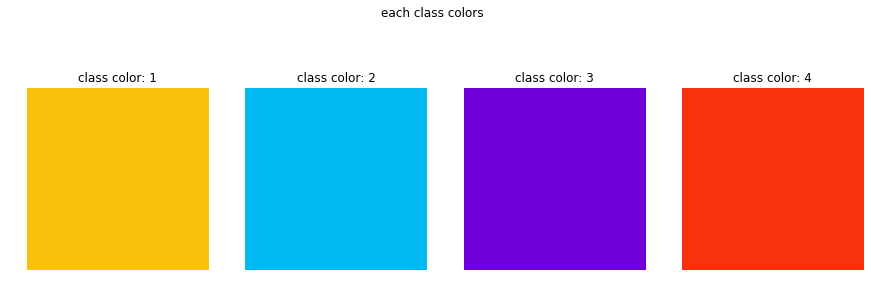

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [20]:
idx_no_defect = []
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []
idx_class_multi = []
idx_class_triple = []

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        idx_no_defect.append(col)
    elif (labels.isna() == [False, True, True, True]).all():
        idx_class_1.append(col)
    elif (labels.isna() == [True, False, True, True]).all():
        idx_class_2.append(col)
    elif (labels.isna() == [True, True, False, True]).all():
        idx_class_3.append(col)
    elif (labels.isna() == [True, True, True, False]).all():
        idx_class_4.append(col)
    elif labels.isna().sum() == 1:
        idx_class_triple.append(col)
    else:
        idx_class_multi.append(col)

### images with no defect

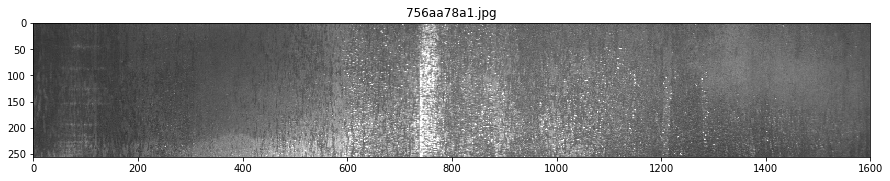

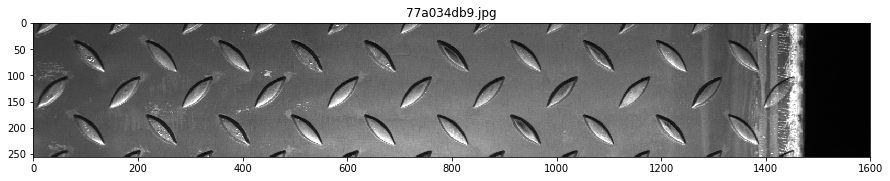

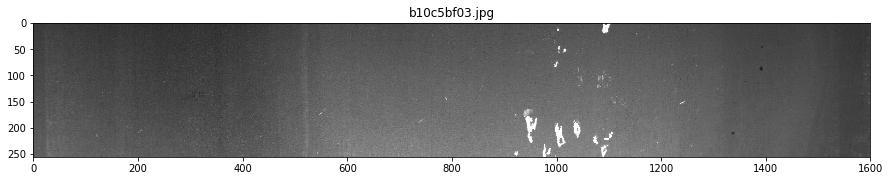

In [21]:
for idx in idx_no_defect[:3]:
    show_mask_image(idx)

### images with defect(label: 1)

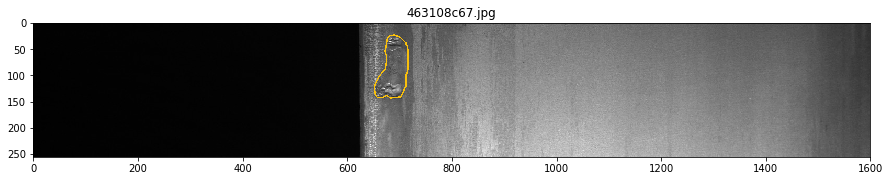

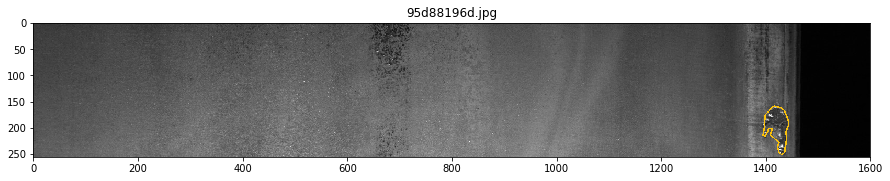

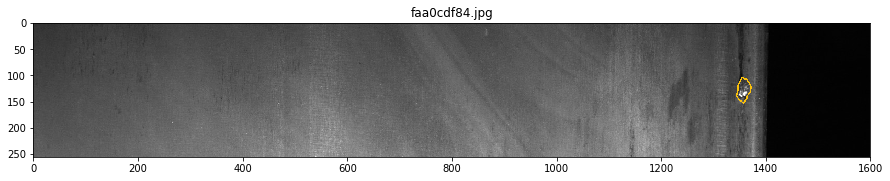

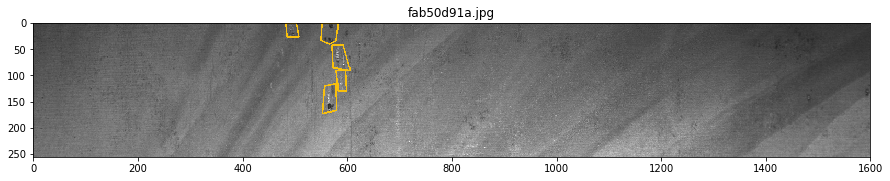

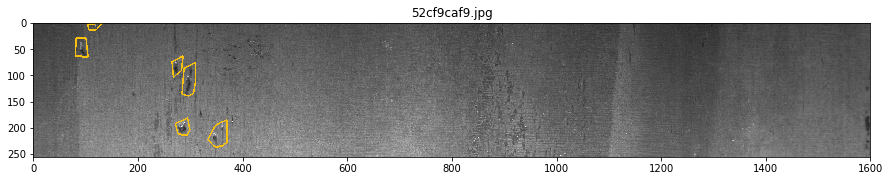

In [22]:
for idx in idx_class_1[:5]:
    show_mask_image(idx)

### images with defect(label: 2)

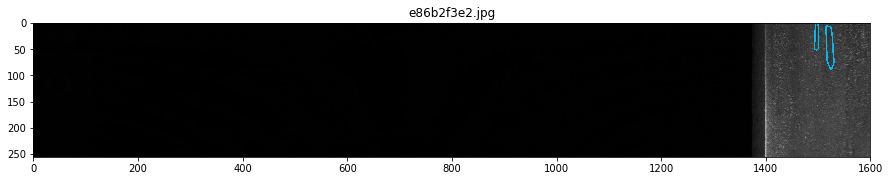

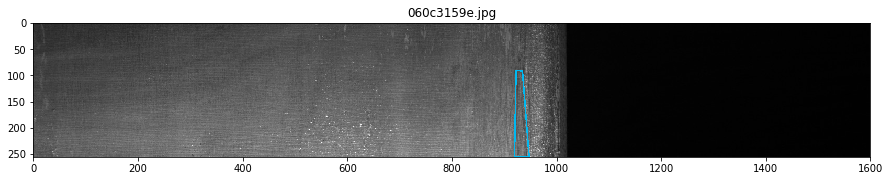

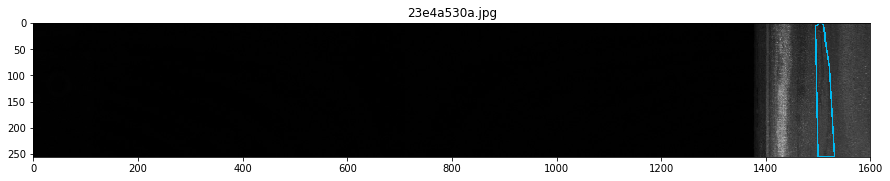

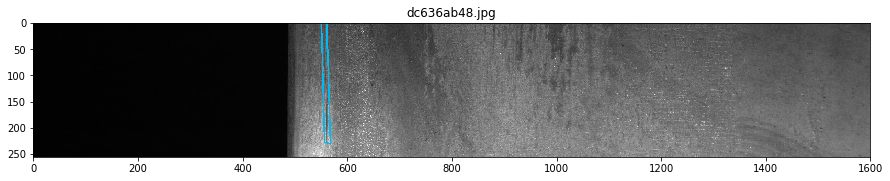

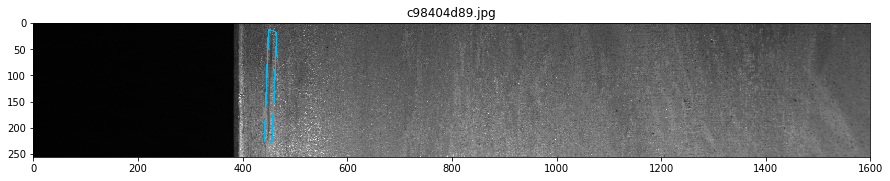

In [23]:
for idx in idx_class_2[:5]:
    show_mask_image(idx)

### images with defect(label: 3)

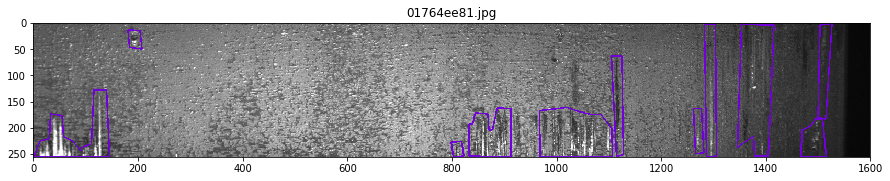

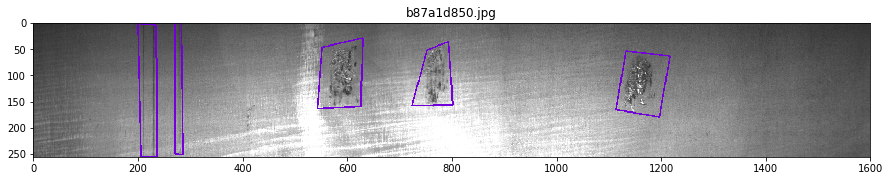

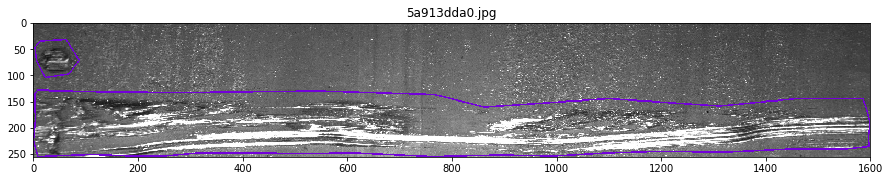

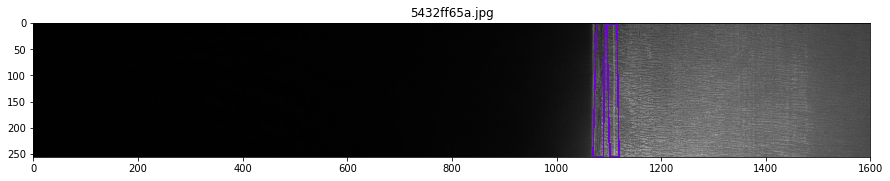

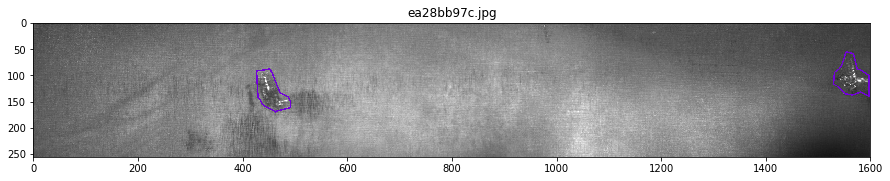

In [24]:
for idx in idx_class_3[:5]:
    show_mask_image(idx)

### images with defect(label: 4)

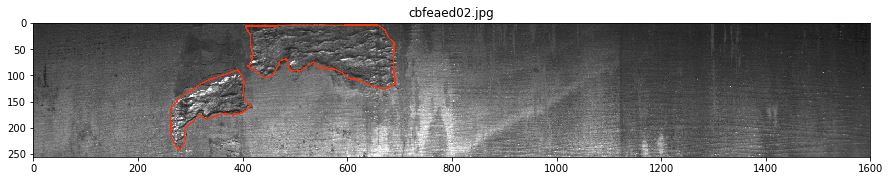

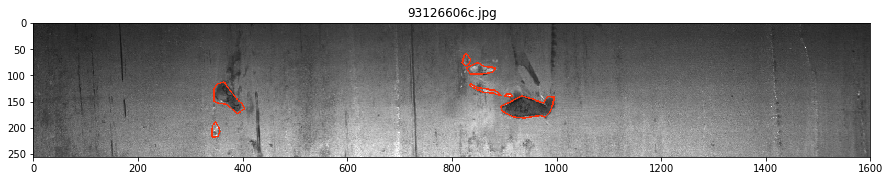

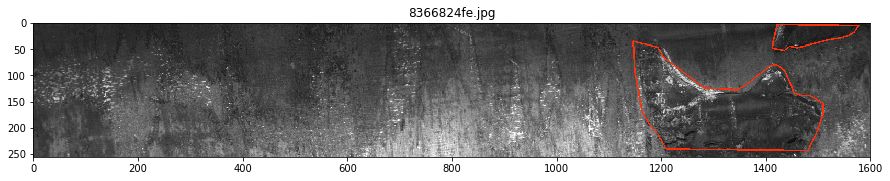

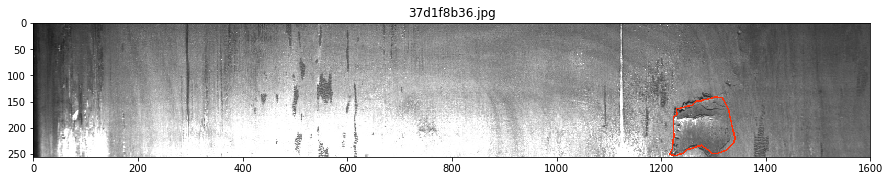

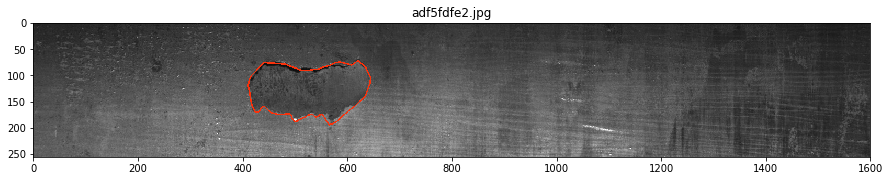

In [25]:
for idx in idx_class_4[:5]:
    show_mask_image(idx)

### images with multiple defects

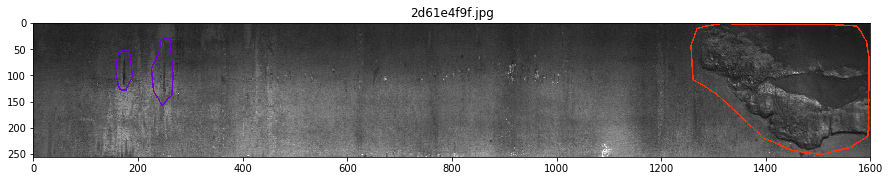

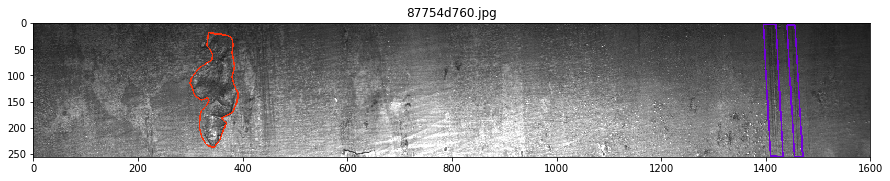

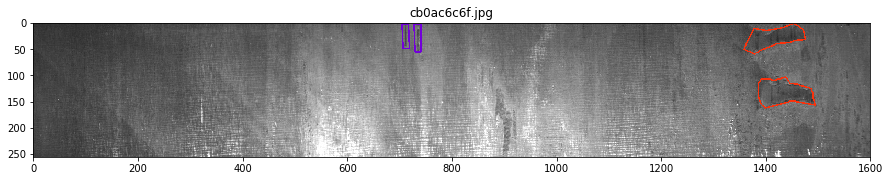

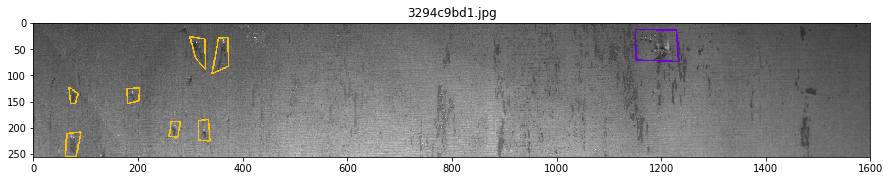

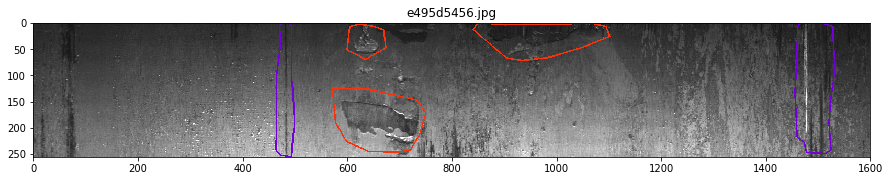

In [26]:
for idx in idx_class_multi[:5]:
    show_mask_image(idx)